In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation

# Open the netcdf files

In [2]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/lattice_boltzmann_rotors/ethan_output/output_eastriver"

In [3]:
# List all files in the data directory
files = [f for f in os.listdir(data_dir) if f.endswith('.nc')]

# Function to extract timestep from filename
def extract_timestep(filename):
    # Assuming the timestep is the last 4 characters before the file extension
    return int(filename[-7:-3])

# Dictionary to store data with new time index
data_with_time_index = {}

# Process each file
for file in files:
    # Extract timestep
    timestep = extract_timestep(file)
    
    # Open the file
    file_path = os.path.join(data_dir, file)
    data = xr.open_dataset(file_path)
    
    # Create a new time index based on the timestep
    data = data.assign_coords(time=timestep)
    
    # Store the data
    data_with_time_index[file] = data

# Now data_with_time_index contains all the data with the new time index

In [4]:
output_dataset = xr.concat(data_with_time_index.values(), dim='time').sortby('time')

# Sort the data into a dataset that makes sense

In [5]:
# Select data where y=1 and y=2
u_data = output_dataset.sel(y=0).sel(r=0)
v_data = output_dataset.sel(y=1).sel(r=0)

In [6]:
vel_data = xr.merge([
    u_data.rename_vars(u='u'),
    v_data.rename_vars(u='v')
])

In [7]:
print(vel_data.isel(time=0).x.values.shape)
print(vel_data.isel(time=0).z.values.shape)
print(vel_data.isel(time=0).u.values.shape)
print(vel_data.isel(time=0).v.values.shape)
print()

(1280,)
(384,)
(384, 1280)
(384, 1280)



# Plot that ish

In [8]:
profile_ds = xr.open_dataset('profile.nc')

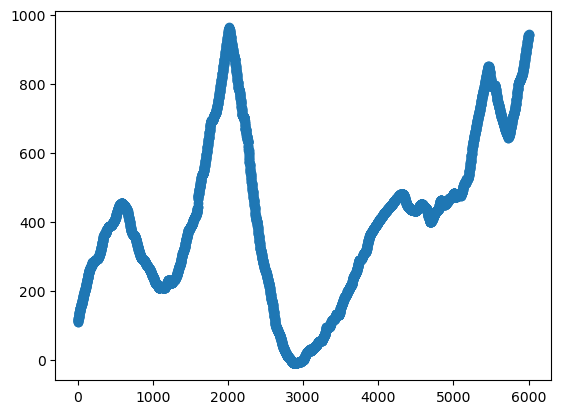

In [9]:
plt.scatter(
    np.linspace(0, len(profile_ds.data), len(profile_ds.data)),
    profile_ds.data, 
)

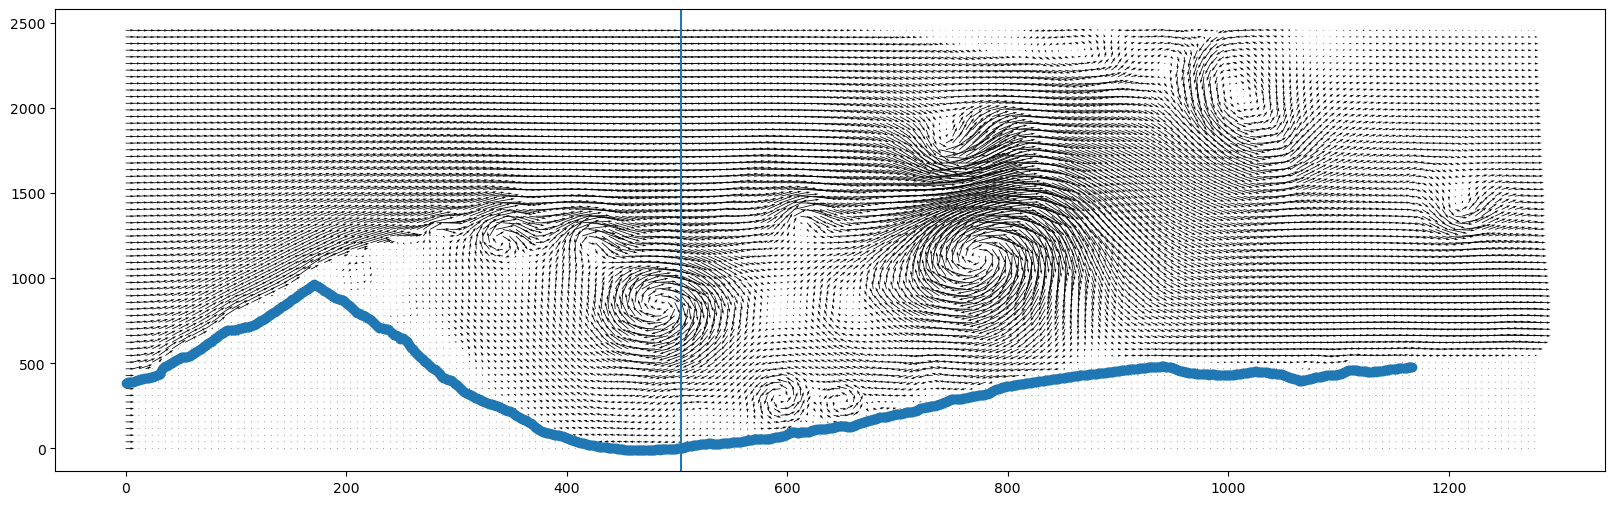

In [10]:
X, Z = np.meshgrid(vel_data.x.values, vel_data.z.values)

SKIP = 6
plt.figure(figsize=(20,6))
Z = Z*6.5
plt.quiver(
    X[::SKIP, ::SKIP],
    Z[::SKIP, ::SKIP],
    vel_data.isel(time=0).u.values[::SKIP, ::SKIP],
    vel_data.isel(time=0).v.values[::SKIP, ::SKIP],
    scale=250,
    width=0.0005
)
plt.scatter(
    np.linspace(0, len(profile_ds.data.values[1500:5000:3]), len(profile_ds.data.values[1500:5000:3])),
    profile_ds.data.values[1500:5000:3], 
)
plt.axvline(170 + 2000/2/3)

# Simulate doppler lidar scan!

Place the radar at x = 800, z = 0. Iterate at elevation angles of 1˚, at range-intervals of 15m.

In [11]:
vel_data_one_frame = vel_data.isel(time=0)

Adjust the x dimension of the dataset so the DL is at x=0 (and z=0). We guessed above,
that the DL is at the x index:

170 + 2000/2/3

b/c the DL is approx 2km from gothic peak, which we identified as at x index 170; then profile dataset had a horizontal resolution of 2 (1.99993 m), and Ethan skipped every third value, giving 2000/2/3.

In [12]:
horizontal_adjust = 170 + 2000/2/3

In [13]:
vel_data_one_frame = vel_data_one_frame.assign_coords({"x": (vel_data_one_frame.x - horizontal_adjust).values})
vel_data_one_frame = vel_data_one_frame.assign_coords({"z": (vel_data_one_frame.z).values})

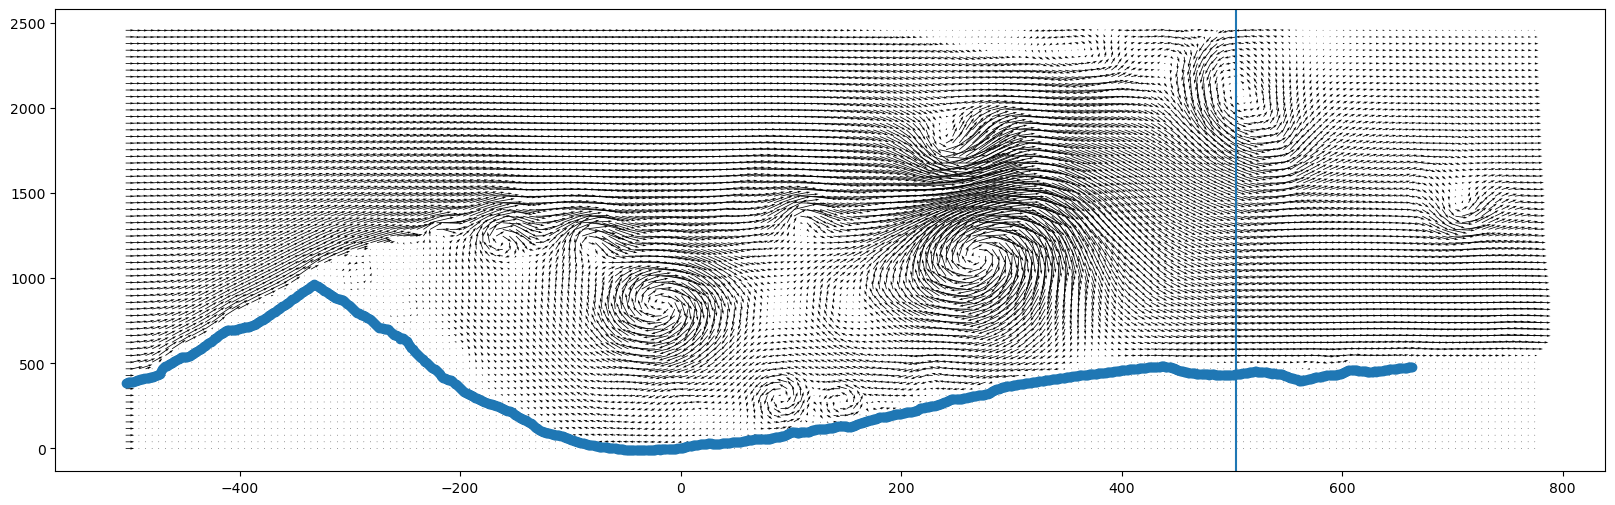

In [14]:
X, Z = np.meshgrid(vel_data_one_frame.x.values, vel_data_one_frame.z.values)

SKIP = 6
plt.figure(figsize=(20,6))
Z = Z*6.5
plt.quiver(
    X[::SKIP, ::SKIP],
    Z[::SKIP, ::SKIP],
    vel_data_one_frame.u.values[::SKIP, ::SKIP],
    vel_data_one_frame.v.values[::SKIP, ::SKIP],
    scale=250,
    width=0.0005
)
plt.scatter(
    np.linspace(0, len(profile_ds.data.values[1500:5000:3]), len(profile_ds.data.values[1500:5000:3])) - horizontal_adjust,
    profile_ds.data.values[1500:5000:3], 
)
plt.axvline(170 + 2000/2/3)

In [15]:
vel_data_one_frame.x.min().values.item(), vel_data_one_frame.x.max().values.item()

(-503.3333333333333, 775.6666666666667)

Simulate the scan

In [16]:
# define function for converting from radial to polar coordinates
# remember: WE GO COUNTERCLOCKWISE FROM 0˚ on the unit circle

In [17]:
def cartesian_convert(elevation,range):
    x = range*np.cos(np.deg2rad(elevation))
    y = range*np.sin(np.deg2rad(elevation))
    return x, y

In [18]:
us = []
vs = []
df = []
# iterate over elevation values and range values
for elevation in np.linspace(0,180, 181):
    for range in np.linspace(0,800, 101):
        x, z = cartesian_convert(elevation, range)
        u = vel_data_one_frame.u.interp(x=x, z=z, method='linear')
        v = vel_data_one_frame.v.interp(x=x, z=z, method='linear')
        radial_velocity_magnitude = u*np.cos(np.deg2rad(elevation)) + v*np.sin(np.deg2rad(elevation))

        df.append({
            'u'         : u.values.item(),
            'v'         : v.values.item(),
            'elevation' : elevation,
            'range'     : range,
            'x'         : x,
            'z'         : z,
            'r_vel'     : radial_velocity_magnitude.values.item()
        })

In [19]:
df = pd.DataFrame(df)
# df['r_velu'] = df['u']*np.cos(np.deg2rad(elevation))
# df['r_velv'] = df['v']*np.sin(np.deg2rad(90 - elevation))
# df['r_vel'] = df['r_velu'] + df['r_velv']

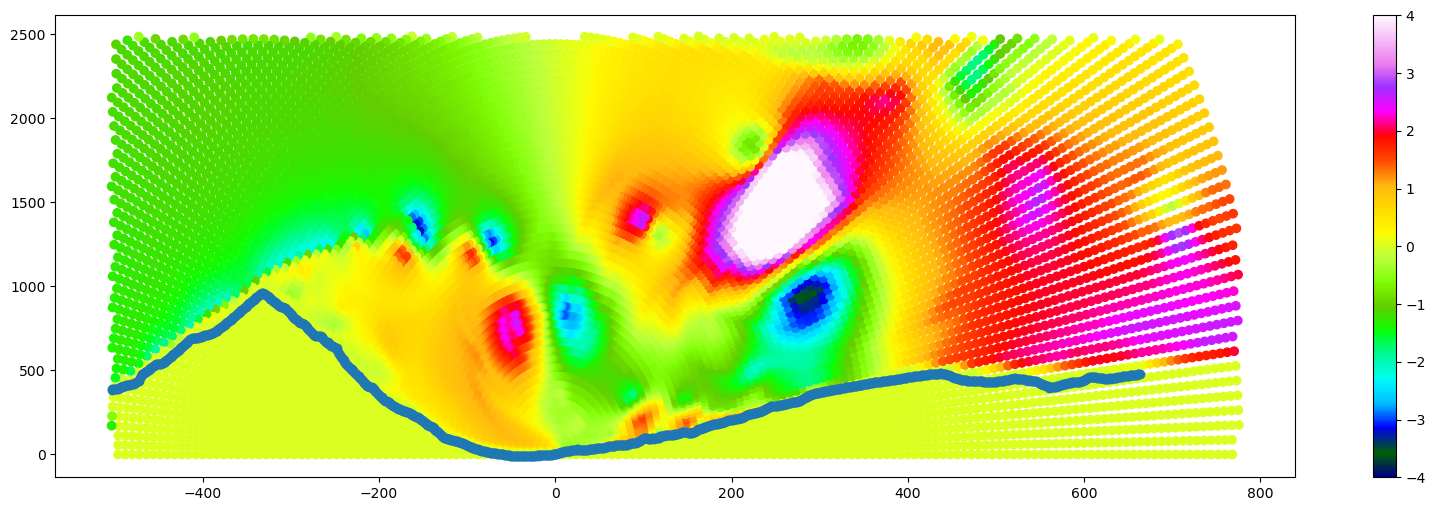

In [20]:
plt.figure(figsize=(20,6))
src = df.copy()
Z = src.z*6.5
plt.scatter(
    src.x, Z, c=src.r_vel,
    cmap='gist_ncar',
    # cmap='RdYlBu',
    vmin=-4,
    vmax=4
)
# plt.gca().set_aspect('equal')
plt.colorbar()
plt.scatter(
    np.linspace(0, len(profile_ds.data.values[1500:5000:3]), len(profile_ds.data.values[1500:5000:3])) - horizontal_adjust,
    profile_ds.data.values[1500:5000:3], 
)

Open up an actual scan, mimic plotting from another notebok

In [21]:
actual_scan_file = '/Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.20230419.021833.cdf'


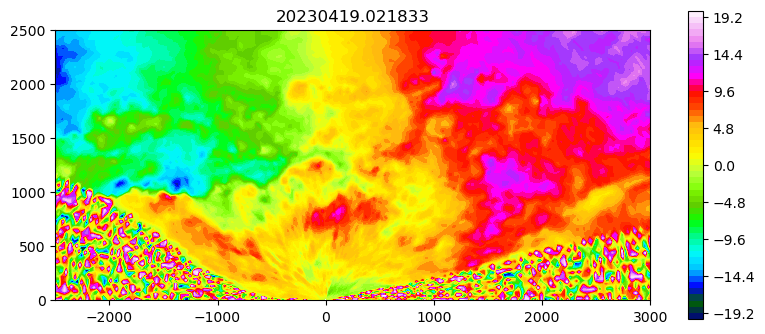

In [58]:
actual_scan_ds = xr.open_dataset(actual_scan_file)
actual_scan_ds['x'] = actual_scan_ds['range']*np.cos(np.deg2rad(actual_scan_ds['elevation']))
actual_scan_ds['z'] = actual_scan_ds['range']*np.sin(np.deg2rad(actual_scan_ds['elevation']))
src = actual_scan_ds.sel(range=slice(0,4000))
src = src.assign(x = - src.x )
plt.subplots(figsize=(9.6, 4))
plt.contourf(
    src['x'].values.T, src['z'].values.T,
    src['radial_velocity'].values,
    cmap='gist_ncar',
    levels=50
)
plt.colorbar()
plt.gca().set_aspect('equal')
name = actual_scan_file.split('gucdlrhiM1.b1/gucdlrhiM1.b1.')[1][:-4]
plt.title(name)
plt.xlim(-2500,3000)
plt.ylim(0,2500)
plt.show()


In [59]:
src

<xarray.Dataset> Size: 577kB
Dimensions:                 (time: 179, range: 133)
Coordinates:
  * time                    (time) datetime64[ns] 1kB 2023-04-19T02:18:33.709...
  * range                   (range) float32 532B 15.0 45.0 ... 3.975e+03
Data variables: (12/14)
    base_time               datetime64[ns] 8B ...
    time_offset             (time) datetime64[ns] 1kB ...
    qc_time                 (time) int32 716B ...
    azimuth                 (time) float32 716B ...
    elevation               (time) float32 716B -0.01 0.0 1.06 ... 180.0 180.0
    radial_velocity         (time, range) float32 95kB -0.7262 -0.2293 ... 13.42
    ...                      ...
    attenuated_backscatter  (time, range) float32 95kB ...
    lat                     float32 4B ...
    lon                     float32 4B ...
    alt                     float32 4B ...
    x                       (range, time) float32 95kB -15.0 -15.0 ... 3.975e+03
    z                       (range, time) float32 95kB -0.002618 ... -0.0003475
Attributes: (12/33)
    command_line:                dl_ingest --max-runtime 0 -s guc -f M1
    process_version:             ingest-dl-2.25-0.el7
    dod_version:                 dlrhi-b1-1.1
    site_id:                     guc
    facility_id:                 M1: Mt Crested Butte, Colorado
    input_source:                /data/collection/guc/gucdlM1.00/User5_193_20...
    ...                          ...
    datastream:                  gucdlrhiM1.b1
    home_point_azimuth:          259.100006
    target_latitude:             38.953799
    target_longitude:            -106.987863
    target_altitude:             2881.000000
    history:                     created by user dsmgr on machine prod-proc2....

In [60]:
src = df.set_index(['x', 'z'])
src = src[~src.index.duplicated(keep='first')]
src = src.to_xarray()

In [61]:
src

<xarray.Dataset> Size: 10GB
Dimensions:    (x: 18101, z: 14207)
Coordinates:
  * x          (x) float64 145kB -800.0 -799.9 -799.5 ... 799.5 799.9 800.0
  * z          (z) float64 114kB 0.0 9.797e-16 1.959e-15 ... 799.5 799.9 800.0
Data variables:
    u          (x, z) float64 2GB nan nan nan nan nan ... nan nan nan nan nan
    v          (x, z) float64 2GB nan nan nan nan nan ... nan nan nan nan nan
    elevation  (x, z) float64 2GB nan nan nan nan nan ... nan nan nan nan nan
    range      (x, z) float64 2GB nan nan nan nan nan ... nan nan nan nan nan
    r_vel      (x, z) float64 2GB nan nan nan nan nan ... nan nan nan nan nan

In [50]:
X, Z = np.meshgrid(src.x, src.z)

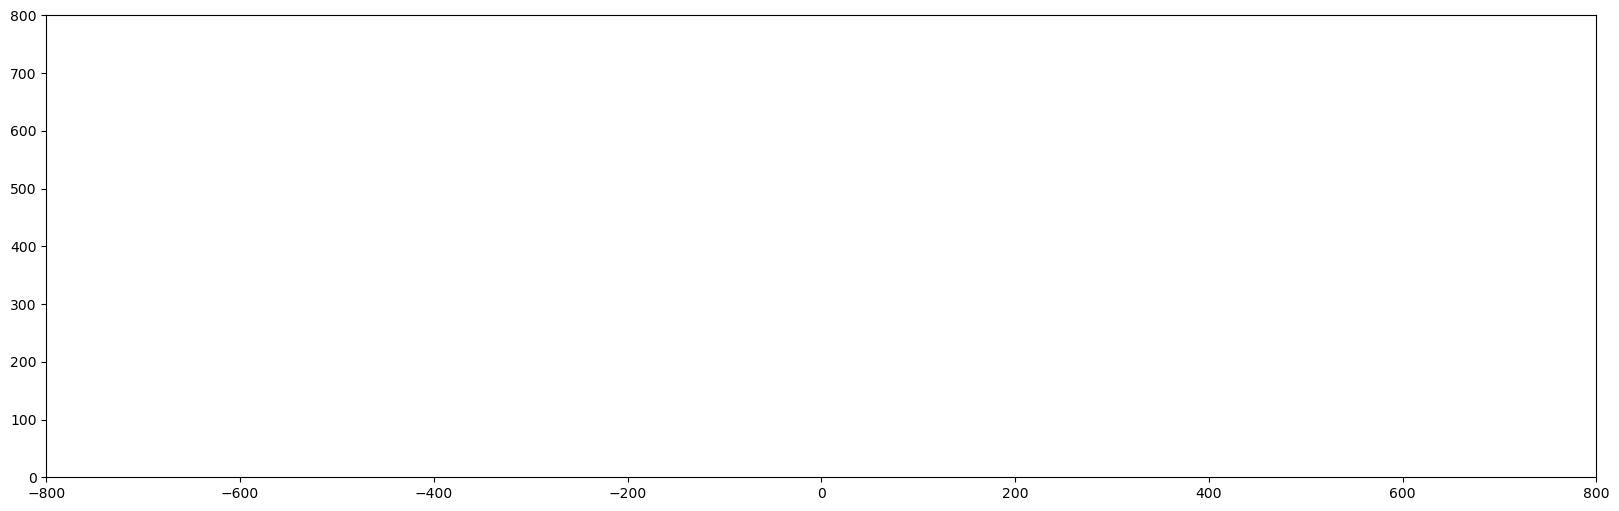

In [62]:
masked_data = np.ma.masked_invalid(src.r_vel)

plt.figure(figsize=(20,6))
plt.contourf(
    X.T, 
    Z.T, 
    src.r_vel,
    cmap='gist_ncar',
    levels=50
)
# plt.colorbar()
# plt.gca().set_aspect('equal')
# name = actual_scan_file.split('gucdlrhiM1.b1/gucdlrhiM1.b1.')[1][:-4]
# plt.title(name)
# plt.xlim(-2500,3000)
# plt.ylim(0,2500)
# plt.show()
